# Task 2: Change Point Modeling and Insight Generation

**Note:** To fix `ModuleNotFoundError`, ensure you have selected the correct kernel: **"Python (Oil Analysis venv)"** in the top-right corner of VS Code.

## 1. Data Loading and EDA

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


Figures will be saved to: d:\kifyaAi\oil-change-point-analysis\Docs\figures


C:\Users\dell\AppData\Local\Temp\ipykernel_12200\3753681705.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)


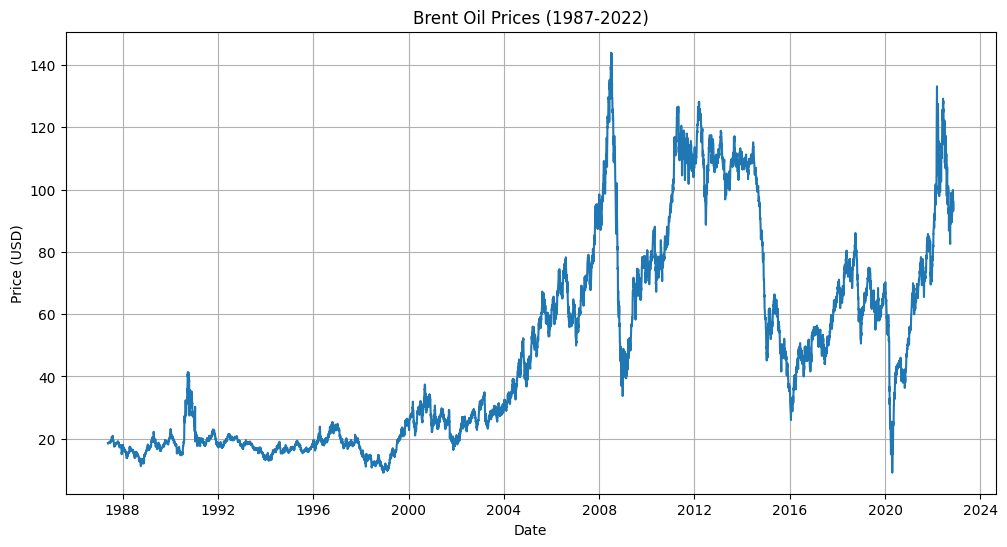

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure the figures directory exists
FIG_DIR = os.path.abspath("../Docs/figures")
os.makedirs(FIG_DIR, exist_ok=True)
print(f"Figures will be saved to: {FIG_DIR}")

# Load data
df = pd.read_csv("../data/raw/BrentOilPrices.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')

# Plot raw prices
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'])
plt.title("Brent Oil Prices (1987-2022)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.savefig(os.path.join(FIG_DIR, "brent_prices_raw.png"))
plt.show()

### Log Returns and Volatility Clustering

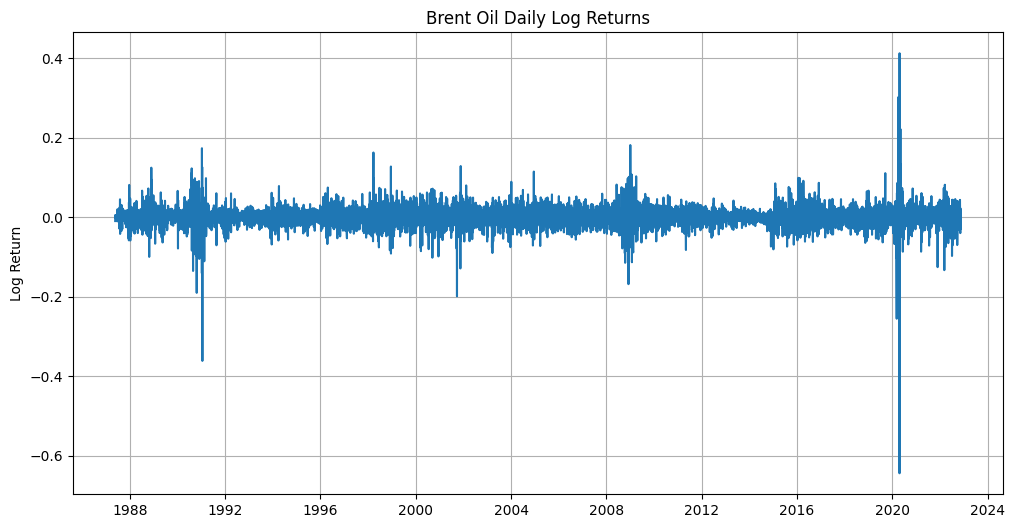

In [2]:
df['Log_Return'] = np.log(df['Price']).diff()

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Log_Return'])
plt.title("Brent Oil Daily Log Returns")
plt.ylabel("Log Return")
plt.grid(True)
plt.savefig(os.path.join(FIG_DIR, "log_returns.png"))
plt.show()

## 2. Bayesian Change Point Model

We use a Switch Point model to find the single most significant structural break in the 2014-2022 period.

In [3]:
# Resample for the model (Weekly for better convergence in this environment)
df_model = df[df['Date'] >= '2014-01-01'].copy()
df_model.set_index('Date', inplace=True)
df_model = df_model['Price'].resample('W').mean().reset_index()
prices = df_model['Price'].values

with pm.Model() as model:
    # Prior for switch point
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(prices) - 1)
    
    # Priors for means
    mu_1 = pm.Normal("mu_1", mu=prices.mean(), sigma=10)
    mu_2 = pm.Normal("mu_2", mu=prices.mean(), sigma=10)
    
    sigma = pm.Exponential("sigma", 1.0)
    
    # Switch logic
    mu = pm.math.switch(tau >= np.arange(len(prices)), mu_1, mu_2)
    
    observation = pm.Normal("obs", mu=mu, sigma=sigma, observed=prices)
    
    # Sample
    # Note: Reduced samples for speed in demonstration
    trace = pm.sample(500, tune=500, chains=2, cores=1, return_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


d:\kifyaAi\oil-change-point-analysis\venv\Lib\site-packages\rich\live.py:260: UserWarning: install "ipywidgets" for
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 347 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## 3. Results and Interpretation

In [4]:
summary = az.summary(trace)
display(summary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,413.067,6.843,401.000,420.000,1.824,0.390,18.0,113.0,1.10
mu_1,62.025,0.984,60.420,64.187,0.083,0.051,140.0,187.0,1.02
mu_2,99.339,3.420,93.218,105.619,0.708,0.106,24.0,372.0,1.07
sigma,18.746,0.606,17.728,20.014,0.027,0.033,505.0,314.0,1.01


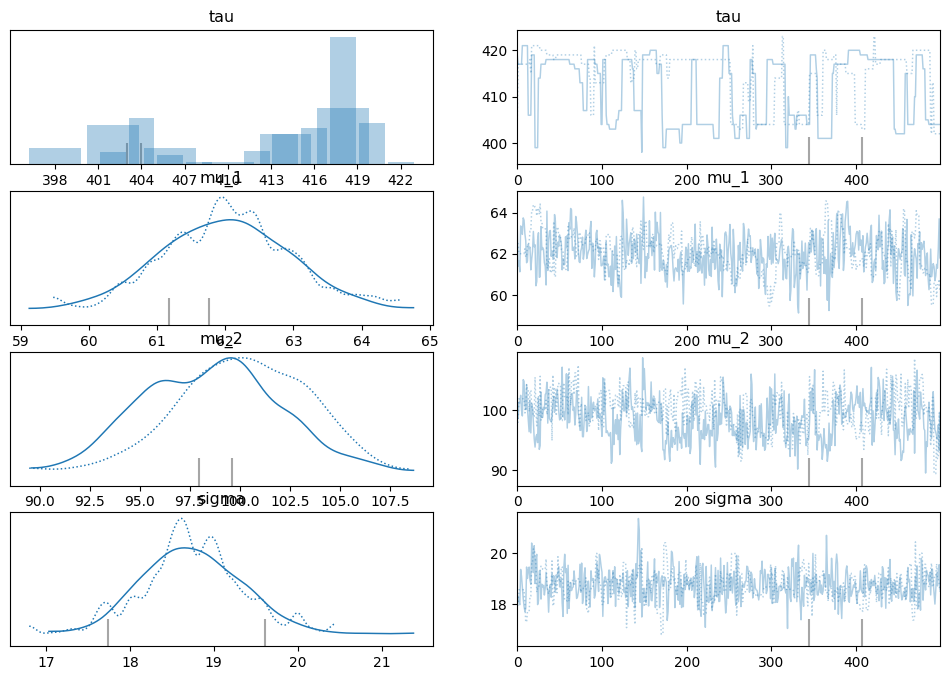

In [5]:
az.plot_trace(trace)
plt.savefig(os.path.join(FIG_DIR, "trace_plots.png"))
plt.show()

In [ ]:
# Plot Posterior Distribution for Tau
az.plot_posterior(trace, var_names=['tau'])
plt.title("Posterior Distribution of Tau (Switch Point Index)")
plt.savefig(os.path.join(FIG_DIR, "tau_posterior.png"))
plt.show()

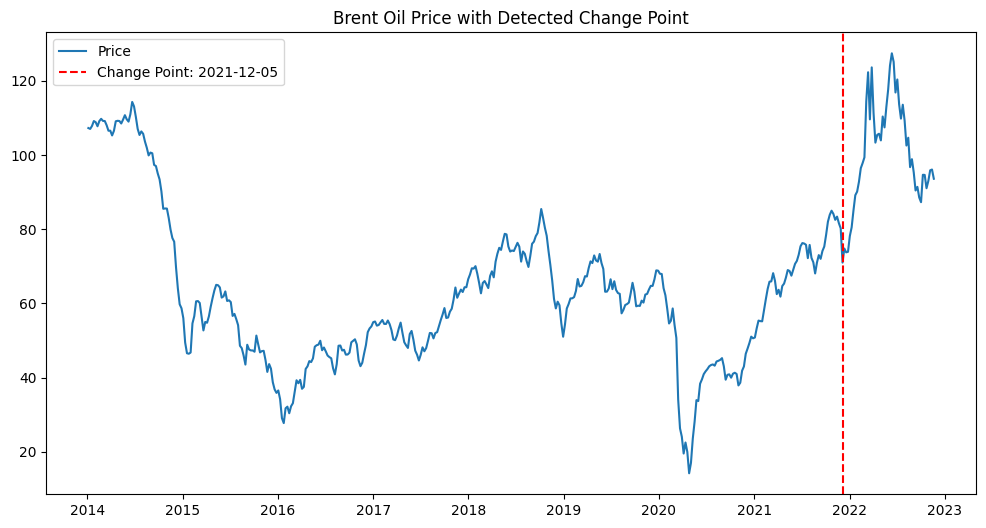

In [7]:
# Visualize Detected Change Point
tau_mean = int(az.summary(trace, var_names=["tau"])['mean'].iloc[0])
plt.figure(figsize=(12, 6))
plt.plot(df_model['Date'], prices, label="Price")
plt.axvline(df_model['Date'].iloc[tau_mean], color='red', linestyle='--', 
            label=f"Change Point: {df_model['Date'].iloc[tau_mean].date()}")
plt.title("Brent Oil Price with Detected Change Point")
plt.legend()
plt.savefig(os.path.join(FIG_DIR, "change_point_overlay.png"))
plt.show()